<a href="https://colab.research.google.com/github/raspopovaa/Pet-Project-Data-Analyst/blob/main/%D0%98%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20%D0%BD%D0%B0%D0%B4%D1%91%D0%B6%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%B7%D0%B0%D1%91%D0%BC%D1%89%D0%B8%D0%BA%D0%BE%D0%B2/%D0%98%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20%D0%BD%D0%B0%D0%B4%D1%91%D0%B6%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%B7%D0%B0%D1%91%D0%BC%D1%89%D0%B8%D0%BA%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
plt.style.use('dark_background')

Импортируем бибилиотеку pandas и загружаем таблицу

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Используем метод info() для выявлнния пропущеных значений в таблице

Используем метод .head(), для визуальной оценки данных.

In [3]:

data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


**Вывод**

Использовав метод info и head, можно сделать вывод, что таблица содержит 21525 строк, 12 столбцов. Столбцы имеют разний тип данных. Таблица удобная для анализа данных - в каждом столбце храняться значения, каждая строка содержит одно наблюдение, к которому приязанны значения разных переменных. Название столбцов без пробелов, несколько слов разделяются нижним подчеркиванием, на одном языке и в одном регистре, отображают в краткой форме какого рода информация содержиться в каждом столбце. Столбцы 'days_employed' (общий трудовой стаж в днях) и 'total_income' (ежемесячный доход) имеют 19351 заполненых строк вместо 21525, т.е имеют около 10 % пропусков значений. Так же в столбце 'days_employed' есть отрицательные значения, чего не может быть с трудовым стажем. Так же отрицательные значения есть в столбце 'children', в столбце dob_years есть нулевые значения, в столбцах 'education', 'family_status' и income_type буквы разного регистра, столбец 'gender' содержит неверное значение XNA. В строке 'dob_years' есть нулевые значения, что недопустимо. Скорее всего это технические ошибки.  Так же предположу, что пропуски в столбцах 'days_employed' (общий трудовой стаж в днях) и 'total_income' (ежемесячный доход) созданны намеренно и связанно это с видом кредита (т.е. есть кредиты не предполагающие предоставление информации о трудовом стаже, и ежемесячном доходе). Интересно, есть ли связь между заполнением этих строк и возвратом кредита в срок. Но вернемся к заданию, необходимо провести предобработку данных для выявления артефактов содержащих недостоверные данные.

## Шаг 2. Предобработка данных

### Обработка пропусков

In [4]:
data.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Было найдено 2174 значения NaN. Нам нужно либо заменить NaN на другое значение, либо удалить полностью строку с пропущенным значением. У каждого метода есть минусы и плюсы. Ответим на вопрос: "Какой метод лучше в нашем случае?" Удаление строки не целесообразно (10% от выбоки, как никак), так как удаление полностью всех строк может повлиять на результат исследования. Добавление нового значения тоже может повлиять на результат в случе если будет совпадать с каким-либо текущим значением. В нашем случае 0 и NaN тождествены. Заменим на 0.

In [5]:
data['days_employed'] = data['days_employed'].abs()
data['total_income'] = data['total_income'].abs()

In [6]:
data.groupby('income_type').agg({'total_income': ['count', 'mean', 'median'],'days_employed': ['count', 'mean', 'median']})

total_income                 ...  days_employed               
                       count           mean  ...           mean         median
income_type                                  ...                              
безработный                2  131339.751676  ...  366413.652744  366413.652744
в декрете                  1   53829.130729  ...    3296.759962    3296.759962
госслужащий             1312  170898.309923  ...    3399.896902    2689.368353
компаньон               4577  202417.461462  ...    2111.524398    1547.382223
пенсионер               3443  137127.465690  ...  365003.491245  365213.306266
предприниматель            1  499163.144947  ...     520.848083     520.848083
сотрудник              10014  161380.260488  ...    2326.499216    1574.202821
студент                    1   98201.625314  ...     578.751554     578.751554

[8 rows x 6 columns]

In [7]:
data = data.fillna(0)

  
Напишем функцию для замены пропусков в столбце total_incom на полученные средние значения.


In [8]:
def total(row):
    total_income = row['total_income']
    income_type = row['income_type']
    if total_income == 0:
        if income_type == 'пенсионер':
            return 137127
        if income_type == 'сотрудник':
            return 161380
        if income_type == 'госслужащий':
            return 170898
        if income_type == 'безработный':
            return 131339
        if income_type == 'в декрете':
            return 53829
        if income_type == 'компаньон':
            return 202417
        if income_type == 'предприниматель':
            return 499163
        if income_type == 'студент':
            return 98201
        
    else:
        return total_income
            
    

   
Напишем функцию для замены пропусков в столбце days_employed на полученные средние значения.


In [9]:
def employed(row):
    days_employed = row['days_employed']
    income_type = row['income_type']
    if days_employed == 0:
        if income_type == 'пенсионер':
            return 365003
        if income_type == 'сотрудник':
            return 2326
        if income_type == 'госслужащий':
            return 3399
        if income_type == 'безработный':
            return 366416
        if income_type == 'в декрете':
            return 3296
        if income_type == 'компаньон':
            return 2111
        if income_type == 'предприниматель':
            return 520
        if income_type == 'студент':
            return 578
        
    else:
        return days_employed
            

In [10]:
data['total_income'] = data.apply(total, axis=1)
data['days_employed'] = data.apply(employed, axis=1)
data.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [11]:
data.isnull().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Вывод**

Для определения и подсчёта пропущенных значений таблицы применим метод .isnull() в сочетании с методом .sum(). В результате мы видим два столбца days_employed и total_income с 2174 строками пропущенных значений. Заполним данные строки заначением 0, используя метод .fillna(). Удаление данных строк методом .dropna() не целесообразно, так как удаление полностью всех строк может повлиять на результат исследования.

### Замена типа данных

Самый простой способ преобразовать столбец данных в другой тип - использовать .astype()

In [12]:
data['days_employed'] = data['days_employed'].astype('int')
data['children'] = data['children'].astype('int')


Целесообразно изменить тип данных в трех столбцах. 'days_employed', 'children', так как из их смысла понятно что они могут быть только целочисленные. 

Так же столбцы 'days_employed', 'children' имют отрицательные значения, что также не являеться верным. Создаем функцию для изменения минуса на плюс, можно использовать метод abs но мы его еще не проходили)).

In [13]:
def modul(num):
    if num < 0:
        num_p = num * -1
        return num_p
    else:
        return num

In [14]:
data['days_employed'] = data['days_employed'].apply(modul)
data['children'] = data['children'].apply(modul) 

Проверим, что получилось.

In [15]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


**Вывод**

Была поставлена задача изменить вещественные тип (float) данных на целочисленный (int). После анализа таблицы были определены столбы с вещественным типом данных 'days_employed', 'children'. Для их изменнеия выбрали метод astype() как самый простой и универсальный. Отрицательные значения изменили в рамках общей задачи предобработки данных.

### Обработка дубликатов

Проверим на дубликаты и удалим их.

In [16]:
data['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

Cтроки отличаются регистром букв. Чтобы учесть такие дубликаты, все символы в строке приводят к нижнему регистру вызовом метода lower(). В Pandas синтаксис .str.lower(). Тем самым мы удалили все дубликаты

In [17]:
data['education'] = data['education'].str.lower()
data['education'].duplicated().sum()


21520

In [18]:
data['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

По аналогии поступим и с другими столцами имющими категориальные типы данных.

In [19]:
data['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

In [20]:
data['family_status'] = data['family_status'].str.lower()
data['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

In [21]:
data['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Наблюдаем появление в данных третьего пола. Кстати в США официально 54 типа половой принадлежности))). В данном случае будем считать это дубликатом появившимся по технической причине, заменим его на f (так как это всего один случай не имеет значения на что менять)

In [22]:
data = data.replace('XNA', 'f')
data['gender'] = data['gender'].str.lower()
data['gender'].value_counts()

f    14237
m     7288
Name: gender, dtype: int64

In [23]:
data['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

Мы видим разные категории, некоторые из которых не отражают тип занятосяти. Предлагаю объеденить некоторые категории с схожи катерии. Сотрудник, безработный и пенсионер.

In [24]:
data['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

<function matplotlib.pyplot.show>

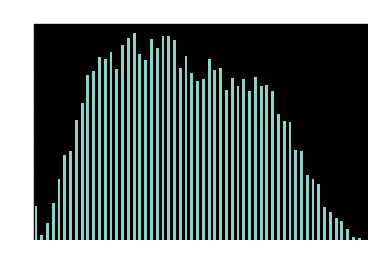

In [25]:
plt.title ('Распределение клиентов по возрасту')
data['dob_years'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.show

В столбце есть 101 значение равно 0. Предполагаю, что эо так же техническая ошибка. Заменим 0 на среднее значение по столбцу или медиану.

In [26]:
data.dropna(subset=['dob_years'], inplace=True)

In [27]:
data['dob_years'].value_counts()

35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
66    183
22    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: dob_years, dtype: int64

**Вывод**

В таблице присутствовало множество дубликатов. Мы удалили дубликаты приведя все знаки в строках к нижнему регистру, в ручном режиме объеденили некоторые группы значений, заменили отсутствующие значения на средние по столбцу. Данные дубликаты возникали в связи с техническими ошибками.

### Лемматизация

Для лемматизацмм будем использовать бибилитеку pymystem3. Импортируем её

In [28]:
%pip install pymystem3 -U
import pandas as pd
from pymystem3 import Mystem
m = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


<div class="alert alert-block alert-warning">
<b>Комментарий от ревьюера</b>

Импорт всех библиотек лучше делать в начале работы в отдельной ячейке. Так будет понятно, что ты использовал :)
</div>

Создадим функию для лемматизации и для подсчета значений

In [29]:
def lemmatize(str):
    return m.lemmatize(str)
 
def counter(str):
    from collections import Counter
    return Counter(str)
 


С помощью метода apply пременим фунцию для лемматизации слов в столбце purpose.

In [ ]:
data['lemm_purpose'] = data['purpose'].apply(lemmatize).apply(counter)
data.head(3)

**Вывод**

Применив созданную нами фенкцию Lemmatize и counter для лемматизции и посчета значений в столбце purpose, можно выделить несколько целей кредита - Автомобиль, жилье, недвижимость, свадьба, образование. Разобьем целина эти категории.

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера</b>

Молодец! Ты разобрался с лемматизацией и даже подсчитал сколько раз встречается слово в строке. Поехали дальше!
</div>

### Категоризация данных

Для наглядности последующих расчетов, разобьем на категории столбцы lemm_purpose, dob_years, children, total_income, .

In [ ]:
def lem_group(word):
    if 'свадьба' in word:
        return 'кредит на общие нужды'
    elif 'образование' in word:
        return 'кредит на образование'
    elif 'жилье' in word or 'недвижимость' in word:
        return 'кредит на недвижимость'
    elif 'автомобиль' in word:
        return 'автокредит'
    else:
        return 'нужно проверить лемму'

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера</b>

Классное решение, добавить вывод возможной ошибки! 
</div>

In [ ]:
data['lemm_purpose_group'] = data['lemm_purpose'].apply(lem_group)
data['lemm_purpose_group'].value_counts()

Цели кредита разделили исходя из текущих видов кредитования в банках. Кредит на авто - Автокердит, кредит на приобретение жилья - кредит на недвижимость, кредит на разные цели -кредит на общие нужды.

<div class="alert alert-block alert-danger">
<b>Комментарий от ревьюера</b>

~Cвадьбу и образование сложно назвать одинаковыми общими целями. Всё таки к образованию люди подходят осознаннее. К тому же, родители могут брать кредиты на детей в случае учебы. На свадьбу тоже могут, кончено, но, всё-таки это разные цели.Лучше ничего не объединять здесь,пусть будут 4 кредита ~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий от студента</b> <a class="tocSkip"></a>
    
Вснес изменения в код, добавил вид кредита - "кредит на образование"
</div>


<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера. V.2.</b>

Вижу :)
</div>

Категоризируем возраст клиента на молодых, взрослых и старых. Эти значения пригодяться для оценки взаимосвязи между возрастом заемщиков и возвратом кдита в срок. Для этого создадим фнкцию age_group и применим к соответствующему столбцу.

In [ ]:
def age_group(age):
    if age <= 17:
        return 'молодой'
    elif age <= 64:
        return 'взрослый'
    elif age >= 65:
        return 'старый'
    else:
        return 'нужно проверить значение'
    
       

In [ ]:
data['dob_age_group'] = data['dob_years'].apply(age_group)
data['dob_age_group'].value_counts()


<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера</b>

Всё верно, только немного грустно, что молодые до 17 :)
</div>

Категоризируем количество детей клиента на бездетных и с детьми . Эти значения пригодяться для оценки взаимосвязи между количеством детей у заемщиков и возвратом кдита в срок. Для этого создадим фнкцию children_group и применим к соответствующему столбцу.

In [ ]:
def children_group(children):
    try:
        if children == 0:
            return 'бездетные'
        else:
            return children
               
    except:
        return 'нужно проверить'

In [ ]:
data['dob_children_group'] = data['children'].apply(children_group)
data['dob_children_group'].value_counts()

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера</b>

Тут всё хорошо :)
</div>

Категоризируем доход клиента на без дохода, бехных, со средним доходом и с высоким доходом. Эти значения пригодяться для оценки взаимосвязи между доходом у заемщиков и возвратом кдита в срок. Для этого создадим фнкцию total_income_group и применим к соответствующему столбцу.

In [ ]:
def total_income_group(total_income):
    if total_income == 0:
        return 'без дохода'
    elif total_income <= 50000:
        return 'бедный'    
    elif total_income < 100000:
        return 'средний доход'
    elif total_income >= 100000:
         return 'высоких доход'
    else:
        return 'нужно проверить значение'

In [ ]:
data['total_income_group'] = data['total_income'].apply(total_income_group)
data['total_income_group'].value_counts()

**Вывод**

Для выполнения последующего задания мы категоризировали данные в необходимых нам столбца. Категоризация поможет нам выявить влияние данных нам параметров на возврат кредита в срок. Для этого мы создали ряд функций для каждого слобца сожержащих несколько условий.

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера</b>
И тут всё верно :)
</div>

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Для выявления зависимости сгруппируем полученый нами столбец 'dob_children_group' и сделаем выводы по столбцу 'debt' с помощью вывода количества, суммы и среднего значения.

In [ ]:
data.groupby('dob_children_group').agg({'debt': ['count', 'sum', 'mean']})


Вывод. Проанализировав данные мы определили, что хуже всех платят заемщики с 20 детьми. Лучше всех платят бездетные (думаю учитывать заемщиков с 5 детьми не стоит, так как слишком маленькая выбока). Существет связь между кол-вом детей и возвратом кредита в срок. Более надежные заемщики - заемщики не имеюющие детей.

<div class="alert alert-block alert-danger">
<b>Комментарий от ревьюера</b>

~Все-таки разница в возврате кредита у семей с одним ребенком или тремя детьми будет. Попробуй сделать таблицу, где будут бездетные и люди с 1,2,3... детьми. Здесь поможет pivot_table :)~
    
    
~Также нам нужны доли должников в каждой группе, т.е. делить число должников в каждой группе надо на число людей в данной группе. Только так мы можем оценить влияние всех параметров на возврат кредита. Это можно вывести не в таблицу, а просто строками.~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий от студента</b> <a class="tocSkip"></a>
    
Я изменил функцию группировки по количеству детей в соответствии с твоими замечаниями, так как значение фунции mean соответствует доле должников в каждой группе (так как в столбце debt есть только два значения 0 и 1), используем её для нахождения доли должников в каждой группе. Для проверки вывел столбцы со значениями count (это общее количество людей в группе) и sum (сумма единиц, т.е. должников), sum/count = mean. Данные вывода я обновил. Данные получены но не через метод pivot_table. 
Метод pivot_table применил для поиска более сложных взимосвязей.
</div>



<div class="alert alert-block alert-danger">
<b>Комментарий от ревьюера. V.2.</b>

Таблица получилась отличной, теперь мы видим информацию по детям.
    
Но, смотри. У нас есть заемщики и часть из них имеет долги, а часть нет. Стоит разделить их. Иначе ты просто считаешь здесь всех подряд, что не имеет никакого смысла :(
    
Лучше немного переделать pivot_table и разделить каждую категорию (бездетные, с 1 ребенком, с 2 детьми и т.п.) на 2: у кого есть просрочки и у кого нет. И добавить общий столбец. И отдельно уже посчитать долю должников. 
    
Это стоит сделать и для всех вопросов в этом шаге.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий от студента V.2/</b> <a class="tocSkip"></a>
    
Добавил сводную таблицу. Надеюсь я правильно понял вот это замечание
    
    Но, смотри. У нас есть заемщики и часть из них имеет долги, а часть нет. Стоит разделить их. Иначе ты просто считаешь здесь всех подряд, что не имеет никакого смысла :( Лучше немного переделать pivot_table и разделить каждую категорию (бездетные, с 1 ребенком, с 2 детьми и т.п.) на 2: у кого есть просрочки и у кого нет. И добавить общий столбец. И отдельно уже посчитать долю должников.
    
Сгруппировал данные по нужному параметру, тут это количество детей. Затем вывел информацию по задолженности в каждой группе. Вывел количество заемщиков в каждой группе. Определил долю должников по каждой группе. Не долю должников от общего количества заемщиков, а долю по каждой группе. Создана подобная таблица по каждому вопросу в этом шаге. Надеюсь правильно понял замечание.
</div>

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера. V.3.</b>

Да, всё верно! У нас есть люди с детьми/без и долгами и люди с детьми/без без долгов.
    
Теперь можно делать выводы.
</div>

In [ ]:
data_pivot = data.pivot_table(index=['dob_children_group'], columns = 'debt', values='days_employed', aggfunc='count')
data_pivot.reset_index()
data_pivot['Количество заемщиков в группе'] = data_pivot[0] + data_pivot[1]
data_pivot['доля должников в %'] = data_pivot[1] / data_pivot['Количество заемщиков в группе'] * 100
data_pivot.sort_values(by = 'доля должников в %', ascending = False)

<div class="alert alert-block alert-info">
<b>Комментарий от студента</b> <a class="tocSkip"></a>
    
~Мы определили взаимосвязь между возрастом заемщика, количеством детей и возвратом кредита в срок.
Из таблицы видно, что 18 % молодых заемщиков имеющих одного ребенка имеют еще и просроченную задолженность. Самые добропорядочные заемщики - старые заемщики без детей, всего 5 %.~
</div>


<div class="alert alert-block alert-info">
<b>Комментарий от студента V.2.</b> <a class="tocSkip"></a>
    
Мы определили взаимосвязь между возрастом заемщика, количеством детей и возвратом кредита в срок.
Из таблицы видно, 10.5 % заемщиков имеющих 20 детей плохо возвращают кредиты. Бездетные заемщики платят лучше чем заемщики с детьми.
</div>

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера. V.3.</b>

Да, много детей это тяжело. Скорее всего 20 это ошибочное значение, но тут вопрос к составителю даных. Так у нас видно, что 4 ребенка тоже не способствуют лидерству :)
    
</div>

In [ ]:
data_pivot_1 = data.pivot_table(index=['dob_children_group'], columns= 'lemm_purpose_group', values='debt', aggfunc='mean')
data_pivot_1.head(15)

<div class="alert alert-block alert-info">
<b>Комментарий от студента</b> <a class="tocSkip"></a>
    

Проверили взаимосвязь между количеством детей, целью кредита и возникновением задолжности. Вывод почти 15% заемщиков имеющих 3 детей и берущих кредит на общие нужды плохо платят. Лучше всего платят заемщики имеющие 2 детей и берущие кредит на  общие нужды.
</div>


In [ ]:
data_pivot_2 = data.pivot_table(index=['dob_children_group'], columns= 'total_income_group', values='debt', aggfunc='mean')
data_pivot_2.head(15)

<div class="alert alert-block alert-info">
<b>Комментарий от студента</b> <a class="tocSkip"></a>
    
Посмтрим свзяь между количеством детей, доходом и возвратом кредита в срок. Хуже всех платят бедные с 3 детьми - 20%.
Лучше всех - бедные бездетные 5%.
</div>


- Есть ли зависимость между семейным положением и возвратом кредита в срок?

Для выявления зависимости сгруппируем полученый нами столбец 'family_status_id' и сделаем выводы по столбцу 'debt' с помощью вывода количества, суммы и среднего значения.

In [ ]:
data.groupby('family_status').agg({'debt': ['count', 'sum', 'mean']})

In [ ]:
data_pivot_f = data.pivot_table(index=['family_status'], columns = 'debt', values='days_employed', aggfunc='count')
data_pivot_f.reset_index()
data_pivot_f['Количество заемщиков в группе'] = data_pivot_f[0] + data_pivot_f[1]
data_pivot_f['доля должников в %'] = data_pivot_f[1] / data_pivot_f['Количество заемщиков в группе'] * 100
data_pivot_f.sort_values(by = 'доля должников в %', ascending = False)

Вывод, связи нет. Все группы почти одинаково допускают просрочки по кредиту.

<div class="alert alert-block alert-danger">
<b>Комментарий от ревьюера</b>

~Здеcь хотелось бы увидеть не безликие 0,1 и т.д., а именно семейное положение. Постарайся вывести его в таблице.~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий от студента</b> <a class="tocSkip"></a>
    
Заменил id  на название семейного положения.
</div>



<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера. V.2.</b>

Есть контакт! :)
</div>

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [ ]:
data.groupby('total_income_group').agg({'debt': ['count', 'mean'],})

In [ ]:
data_pivot_t = data.pivot_table(index=['total_income_group'], columns = 'debt', values='days_employed', aggfunc='count')
data_pivot_t.reset_index()
data_pivot_t['Количество заемщиков в группе'] = data_pivot_t[0] + data_pivot_t[1]
data_pivot_t['доля должников в %'] = data_pivot_t[1] / data_pivot_t['Количество заемщиков в группе'] * 100
data_pivot_t.sort_values(by = 'доля должников в %', ascending = False)

Вывод, связи нет. Все группы почти одинаково допускают просрочки по кредиту.

- Как разные цели кредита влияют на его возврат в срок?

In [ ]:
data.groupby('lemm_purpose_group').agg({'debt': ['count', 'mean'],})

In [ ]:
data_pivot_p = data.pivot_table(index=['lemm_purpose_group'], columns = 'debt', values='days_employed', aggfunc='count')
data_pivot_p.reset_index()
data_pivot_p['Количество заемщиков в группе'] = data_pivot_p[0] + data_pivot_p[1]
data_pivot_p['доля должников в %'] = data_pivot_p[1] / data_pivot_p['Количество заемщиков в группе'] * 100
data_pivot_p.sort_values(by = 'доля должников в %', ascending = False)

**Вывод**

Вывод, связи нет. Все группы почти одинаково допускают просрочки по кредиту.

<div class="alert alert-block alert-danger">
<b>Комментарий от ревьюера</b>

~Этому разделу стоит немного добавить информации :)~
    
    
~Нам нужны доли должников в каждой группе, т.е. делить число должников в каждой группе надо на число людей в данной группе. Только так мы можем оценить влияние всех параметров на возврат кредита. Это можно вывести не в таблицу, а просто строками.~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий от студента</b> <a class="tocSkip"></a>
    
~Доли должников определи с помощью функции mean.~
</div>



<div class="alert alert-block alert-danger">
<b>Комментарий от ревьюера. V.2.</b>

К сожалению, mean() нас тут не спасет. Жду немного других выводов про просрочки :)
</div>

<div class="alert alert-block alert-info">
<b>Комментарий от студента V.2.</b> <a class="tocSkip"></a>
    
С помощью сводной таблицы определили доли должников в каждой группе. Сровнив полученные доли видим что максимальное и минимальное значение отличаеться на 2%. По автокредитам просрочки возникают у 9,3% заемщиков, по кредитам на недвижимость у 7,2 % заемщиков. Думаю взаимосвязь незначительная. 
</div>

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера. V.3.</b>

Отлично!
</div>

## Шаг 4. Общий вывод


<div class="alert alert-block alert-info">
<b>Комментарий от студента</b> <a class="tocSkip"></a>
    
    
Нам была дана таблица с информацией о заемщика имющих разные параметры. Нам было необходимо определить как влияет семейное положение, количество детей, уровень доходаи, цель кредина на возврат кредита в срок. Для этого мы проанализировали таблицу, выявили пропуски и земенили на среднее значение по соответствующей группе, визуально определили дубликаты, часть дубликатов удалили, часть из них исчезла после приведения стороки к нижнему регистру, заменили неправдоподобные значения. Используя инструмены pandas мы убрали весь мусор и привели данные к необходимому типу. Затем катологизировали данные для более наглядного расчета необходимых параметров. Используя группировку данных по заданным столбцам мы вывели выводы по столбу 'dept' через количество, сумму и среднее значение, что позволило нам заявить об присутствии связи между количеством детей и возвратом кредита в срок. К примеру 10 % заёмщиков имеющх 20 детей имеют просрочку по кредиту. С помощью сводных таблиц определи взамосвять не только между количеством детей и просрочкой, но и добавили взаимосвязь от возраста, дохода и цели кредита. 
    
    
   К примеру:
    - 18 % молодых заемщиков имеющих одного ребенка имеют еще и просроченную задолженность. Самые добропорядочные заемщики - старые заемщики без детей, всего 5 %.
    - почти 15% заемщиков имеющих 3 детей и берущих кредит на общие нужды плохо платят. Лучше всего платят заемщики имеющие 2 детей и берущие кредит на общие нужды - 5%.
    - Хуже всех платят бедные с 3 детьми - 20%. Лучше всех - бедные бездетные 5%.
   
</div>


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.

<div class="alert alert-block alert-warning">
<b>Комментарий от ревьюера</b>

Отлично, есть вывод по проделанной работе. Когда ты проверишь данные на дубликаты и сделаешь с ними что-то и разобьешь в таблицах информацию, твои выводы немного поменяются, не забудь их переписать :)
    
Галочки тоже стоит поставить, так ты точно ничего не пропустишь в работе :)
</div>

<div class="alert alert-block alert-info">
<b>Комментарий от студента</b> <a class="tocSkip"></a>
    
Вывод переписал, дубликаты проверял визуально с помощью value_counts. Информацию разбил по таблицам. Спасибо за замечания.
</div>

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера. V.2.</b>

Отлично, у нас есть вывод и доплнительные пояснения по шагам исследования. Хорошо, что тывсё добавил!
    
Еще немного правок и проект выйдет законченным :)
</div>